This notebook is a version of scaamls key recovery demo with the necessary changes to make it work with. (Avoids dependency issues)

It builds upon scaaml.scaaml_intro.key_recovery_demo.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
!pip install scaaml
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
#from scaaml.utils import tf_cap_memory, from_categorical
#from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import load_attack_shard
# scaaml.utils import hex_display, bytelist_to_hex

# Environment setup

In [3]:
from typing import Sequence, List
import numpy.typing as npt
from glob import glob

def pretty_hex(e: int) -> str:
    """Representation of an integer as a zero-padded two-digit hex string."""
    return f"{e:02X}"


def hex_line(chars: Sequence[int], spacer: str = " ") -> str:
    """Render some chars as hex with a spacer between them"""
    h = []
    for e in chars:
        h.append(pretty_hex(e))
    return spacer.join(h)


def hex_display(lst: Sequence[int],
                prefix: str = "",
                color: str = "green") -> None:
    """Display a list of int as colored hex."""
    h = []
    for e in lst:
        h.append(pretty_hex(e))
    hex_representation = prefix + " ".join(h)
    # Assuming you print with some styled color effect
    print(f"{color}: {hex_representation}")  # Example use of the 'color' parameter
def from_categorical(predictions: Sequence[npt.ArrayLike]) -> List[np.intp]:
    "reverse of categorical"
    # note: doing it as a list is significantly faster than a single argmax
    return [np.argmax(p) for p in predictions]

def bytelist_to_hex(lst: Sequence[int], spacer: str = " ") -> str:
    h = []

    for e in lst:
        h.append(pretty_hex(e))
    return spacer.join(h)

def list_shards(file_pattern: str, num_shards: int) -> List[str]:
    return glob(file_pattern)[:num_shards]

In [11]:
config = """{
    "model": "cnn",
    "device": "stm32f415",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_out",
        "sub_bytes_in",
        "key"
    ],
    "attack_bytes": [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "13",
        "14",
        "15"
    ],
    "max_trace_len": 20000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1
    }
}"""

In [12]:
import tensorflow as tf

target = 'stm32f415_tinyaes'
#tf_cap_memory()
target_config = json.loads(config)
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']

## Import the model

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf

#model5000 = tf.keras.models.load_model("stm32f415-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_5000.keras")
model20000 = tf.keras.models.load_model("../models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_20000.keras")

## Dataset paths

In [7]:
#DATASET_GLOB = "/scaaml/scaaml_intro/datasets/%s/test/*" % target_config['algorithm']
DATASET_GLOB = "../datasets/scaaml_datasets/tinyaes/test/*"
shard_paths  = list_shards(DATASET_GLOB, 256)

In [8]:
len(shard_paths)

256

# Single byte recovery

Let's start by recovering one of the 16 bytes to get a sense of how well the attack work.

**Note**: looking at model accuracy is not enough as we need to invert the attack point AND combine the traces scores. See [presentation](https://elie.net/scaaml) for more information

KJØR DENNE HVER GANG; ATTACK BYTE BLIR BYTTET ETTER DEN SISTE CELLLEN KJØRER


In [9]:
# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_in'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

# load model
#model = load_model_from_disk(available_models[ATTACK_POINT][ATTACK_BYTE])

Using our model to predicting bytes attack point value, recovering byte key and combining prediction for the 256 test keys we have in our dataset

In [13]:
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
    keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)
    #x = x[:,:5000,:]

    # prediction
    predictions = model20000.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y)
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack


    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)
    #maxed out ram before i added this, not sure of the actual effect or if it was random
    del keys, pts, x, y, predictions, key_preds, c_preds, c_y

Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

## checking model accuracy & confusion matrix
the model accuracy is very good given that the baseline is 1/256 > 0.04. However accuracy is not enough to assess of
effective the attack is. Instead you need to look at how many traces it takes to recovers 100% of the sub_bytes as visible below.

Looking at the confusion matrix shows that the model perform equaly well on all the predicted value and generalized well: we see a crisp diagonal with no obvious weak points

In [14]:
print("Accuracy: %.2f" % model_metrics['acc'].result())

Accuracy: 0.48


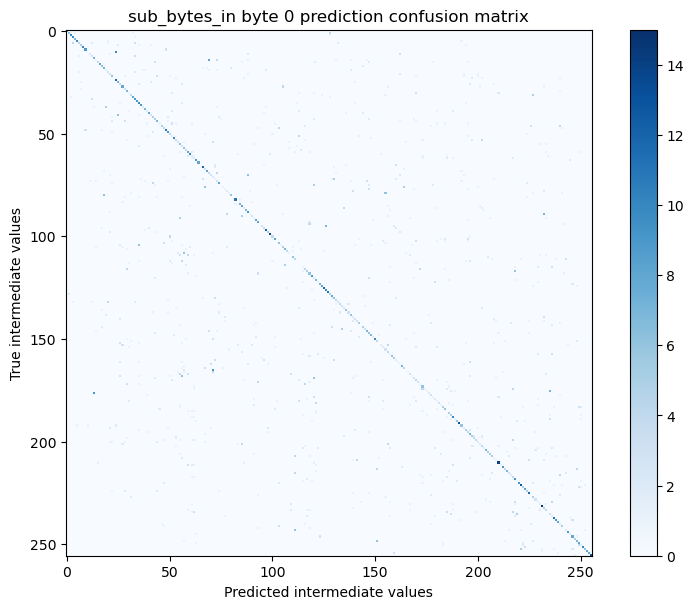

In [15]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))

## byte recovery efficiency


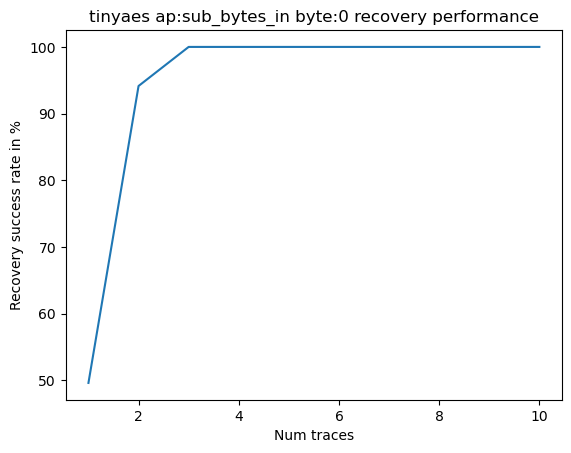

In [16]:
NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

## metric computations

Let's look at some of the various performances metrics that are used to evaluate attack efficency.
- In the worst case for the implementation the attacker can recover ~40% of the key with a single trace.
- The best case is not really better: 4 traces is all you need.

In [17]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-']
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                1     49.6
max traces                3     100.0
cumulative score         81.25  -


# recover the full keys

In [21]:
ATTACK_POINT = 'sub_bytes_in' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 5 # a shard == a different key. Pick the one you would like
NUM_TRACES = 14  # how many traces to use - as seen in single byte, 5 traces is enough

In [24]:
# perfoming 16x the byte recovery algorithm showecased above - one for each key byte
real_key = [] # what we are supposed to find
recovered_key = [] # what we predicted
pb = tqdm(total=16, desc="guessing key", unit='guesses')
for ATTACK_BYTE in range(16):
    # data
    keys, pts, x, y = load_attack_shard(shard_paths[TARGET_SHARD], ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES, full_key=True)
    real_key.append(keys[0])
    x = x[:,:5000,:]
    # load model
    model = model5000

    # prediction
    predictions = model.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    # accumulating probabity
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)

    # order predictions by probability
    guess_ranks = (np.argsort(vals, )[-256:][::-1])

    # take strongest guess as our key guess
    recovered_key.append(guess_ranks[0])

    # update display
    pb.set_postfix({'Recovered key': bytelist_to_hex(recovered_key), "Real key": bytelist_to_hex(real_key)})
    pb.update()


pb.close()

guessing key:   0%|          | 0/16 [00:00<?, ?guesses/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [25]:
# check that everything worked out: the recovered key match the real keys
hex_display(real_key, 'real key')
hex_display(recovered_key, 'recovered key')

green: real key05 E5 73 11 1B 2F A6 B8 3E 78 78 6F 6E 3D 23 C9
green: recovered key05 C9 DC D4 9D 3B FF 3B D0 47 5C 90 F3 23 B7 09


# Congratulation
you were able to use deep learning to recover an AES key with only a few traces.
For more information check out [papers/tutorials](https://elie.net/scaaml/)